# Gaussian Naive Bayesian Classifier

## Implementation

In [1]:
from __future__ import annotations

import numpy as np

In [2]:
class GaussianNaiveBayesianClassifier:
    def fit(self, X: np.ndarray, Y: np.ndarray) -> GaussianNaiveBayesianClassifier:
        self._classes = {int(l) for l in Y}

        self._means = {}
        self._vars = {}
        self._priors = {}

        for c in self._classes:
            x = X[Y==c]
            self._means[c] = np.mean(x, dtype=float, axis=0)
            self._vars[c] = np.var(x, dtype=float, axis=0)

            self._priors[c] = len(x) / len(Y)        

        return self

    def _probability(self, x: np.ndarray, c: int) -> np.ndarray:
        mean = self._means[c]
        var = self._vars[c]

        return 1 / np.sqrt(2 * np.pi * var) * np.exp(-((x - mean)**2) / (2 * var))

    def predict(self, X: np.ndarray) -> np.ndarray:
        probabilities = [
            [self._priors[c] * np.prod(self._probability(x, c)) for c in self._classes] 
            for x in X
        ]

        return np.argmax(probabilities, axis=1)

## Test

In [3]:
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

from typing import Type

In [4]:
def test_classifier(
    classifier_cls: Type[GaussianNaiveBayesianClassifier] | Type[RandomForestClassifier],
    X: np.ndarray, 
    Y: np.ndarray, 
    train_factor: float = 0.6, 
    repeats: int = 20,
    kindly_print_results: bool = True
):
    accuracies, f1_scores, precisions = [], [], []

    for _ in range(repeats):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_factor)
        classifier = classifier_cls()
        classifier.fit(X_train, Y_train)
        Y_predicted = classifier.predict(X_test)
        
        accuracies.append(accuracy_score(Y_test, Y_predicted))
        f1_scores.append(f1_score(Y_test, Y_predicted, average="weighted"))
        precisions.append(precision_score(Y_test, Y_predicted, average="weighted"))

    accuracy, f1score, precision = np.mean(accuracies), np.mean(f1_scores), np.mean(precisions)

    if kindly_print_results:
        print(f"{classifier_cls.__name__}:  accuracy: {accuracy}, f1_score: {f1score}, precision: {precision}")

    return accuracy, f1score, precision

### On iris data

In [5]:
iris = load_iris()
iris_X = iris["data"]
iris_Y = iris["target"]

In [6]:
_ = test_classifier(GaussianNaiveBayesianClassifier, iris_X, iris_Y)

GaussianNaiveBayesianClassifier:  accuracy: 0.9508333333333331, f1_score: 0.950865695675709, precision: 0.9533279693547476


### On breast cancer data (vs Random Forest classifier)

In [7]:
breast_cancer = load_breast_cancer()
breast_cancer_X = breast_cancer["data"]
breast_cancer_Y = breast_cancer["target"]

#### Raw data

In [8]:
_ = test_classifier(GaussianNaiveBayesianClassifier, breast_cancer_X, breast_cancer_Y, train_factor=0.7)

GaussianNaiveBayesianClassifier:  accuracy: 0.9289473684210527, f1_score: 0.9288882748544302, precision: 0.9300570689960276


In [9]:
_ = test_classifier(RandomForestClassifier, breast_cancer_X, breast_cancer_Y, train_factor=0.7)

RandomForestClassifier:  accuracy: 0.962280701754386, f1_score: 0.9621567208806191, precision: 0.962851717993596


#### Standardize data

In [10]:
breast_cancer_X_scaled = StandardScaler().fit_transform(breast_cancer_X)

In [11]:
_ = test_classifier(GaussianNaiveBayesianClassifier, breast_cancer_X_scaled, breast_cancer_Y, train_factor=0.7)

GaussianNaiveBayesianClassifier:  accuracy: 0.9345029239766083, f1_score: 0.9342989640070132, precision: 0.9351639317154767


In [12]:
_ = test_classifier(RandomForestClassifier, breast_cancer_X_scaled, breast_cancer_Y, train_factor=0.7)

RandomForestClassifier:  accuracy: 0.9564327485380115, f1_score: 0.9562384546102848, precision: 0.9571375939449389


#### Reduce dimensionality of data with PCA

In [13]:
breast_cancer_X_pca = PCA(n_components=3).fit_transform(breast_cancer_X_scaled)

In [14]:
_ = test_classifier(GaussianNaiveBayesianClassifier, breast_cancer_X_pca, breast_cancer_Y, train_factor=0.7)

GaussianNaiveBayesianClassifier:  accuracy: 0.9093567251461989, f1_score: 0.9090462014831366, precision: 0.9097268973602122


In [15]:
_ = test_classifier(RandomForestClassifier, breast_cancer_X_pca, breast_cancer_Y, train_factor=0.7)

RandomForestClassifier:  accuracy: 0.9388888888888889, f1_score: 0.9388679596037098, precision: 0.9395831697623223


### Comment

As you can see, data pre-processing such as standardization or dimensionality reduction with PCA has little impact on the results of Gaussian Naive Bayesian classifier. Its results were always slightly worse than for Random Forests.

# Online Bayesian linear Regression

## Implementation

In [16]:
from scipy import stats

In [17]:
class BayesianLinearRegression:
    def __init__(self, n_features: int, alpha: float, beta: float) -> None:
        self._alpha = alpha
        self._beta = beta
        self._mean = np.zeros(n_features + 1) # apply bias
        self._cov_inv = np.identity(n_features + 1) / alpha # apply bias

    def learn(self, x: np.ndarray, y: float) -> BayesianLinearRegression:
        x = np.array([1, *x]) # apply bias

        cov_inv = self._cov_inv + self._beta * np.outer(x, x)

        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self._cov_inv @ self._mean + self._beta * y * x)

        self._cov_inv = cov_inv
        self._mean = mean

        return self
    
    def predict(self, x: np.ndarray):
        x = np.array([1, *x]) # apply bias

        y_pred_mean = x @ self._mean

        w_cov = np.linalg.inv(self._cov_inv)
        y_pred_var = 1 / self._beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
    
    @property
    def weights_dist(self):
        cov = np.linalg.inv(self._cov_inv)
        return stats.multivariate_normal(mean=self._mean, cov=cov)

## Test

In [18]:
import matplotlib.pyplot as plt

### Generate date

In [19]:
w0, w1 = -0.2, 0.6

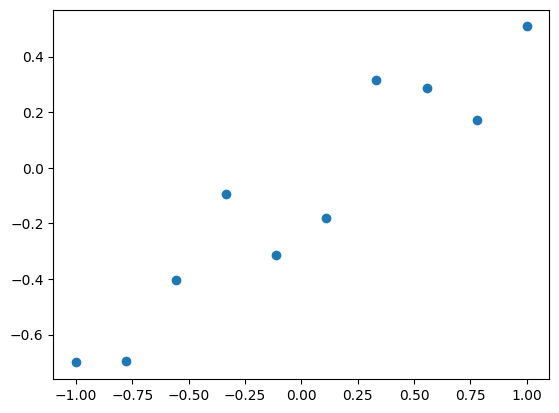

In [20]:
def generate_data(w0: float, w1: float, num_points=10, noise_mean=0., noise_std=0.2) -> tuple[np.ndarray, np.ndarray]:
    np.random.seed(42)

    X = np.linspace(-1, 1, num_points)
    epsilon = np.random.normal(noise_mean, noise_std, num_points)
    T = w0 + w1 * X + epsilon

    return X, T


plt.scatter(*generate_data(w0, w1))

### Visualize regressor learning

In [21]:
def visualize(
        online_regressor: BayesianLinearRegression, 
        steps: int, 
        w0: float, 
        w1: float,
        num_points: int = 10, 
        noise_mean: float = 0., 
        noise_std: float = 0.2,
    ) -> None:
    X, T = generate_data(w0, w1, num_points, noise_mean, noise_std)

    _, axs = plt.subplots(nrows=steps, ncols=3, figsize=(15, steps*5))

    n = 100
    space_1d = np.linspace(-1, 1, n)
    space_2d = np.dstack(np.meshgrid(space_1d, space_1d))
    true_targets = [np.array([1, x]) @ np.array([w0, w1]) for x in space_1d]

    X_past, T_past = [], []


    for i, (x, t) in enumerate(zip(X[:steps], T[:steps])):
        axs[i][0].contourf(space_1d, space_1d, online_regressor.weights_dist.pdf(space_2d))
        axs[i][0].scatter([w0], [w1], color="red")
        axs[i][0].set_title(f"Prior weights distribution (step {i + 1})")

        online_regressor.learn(np.array([x]), t)

        axs[i][1].contourf(space_1d, space_1d, online_regressor.weights_dist.pdf(space_2d))
        axs[i][1].scatter([w0], [w1], color="red")
        axs[i][1].set_title(f"Posterior weights distribution (step {i + 1})")

        axs[i][2].plot(space_1d, true_targets, color="green")

        axs[i][2].scatter(X_past, T_past)
        axs[i][2].scatter([x], [t], marker="*", color="red")

        X_past.append(x)
        T_past.append(t)

        posteriors = [online_regressor.predict(np.array([x])) for x in space_1d]
        predictive_means = [p.mean() for p in posteriors]
        predictive_intervals = [p.interval(0.98) for p in posteriors]
        predictive_intervals_lower = [i[0] for i in predictive_intervals]
        predictive_intervals_upper = [i[1] for i in predictive_intervals]

        axs[i][2].plot(space_1d, predictive_means, linestyle=":")
        axs[i][2].fill_between(space_1d, predictive_intervals_lower, predictive_intervals_upper, alpha=0.1)
        axs[i][2].set_title(f"Posterior target distribution (step {i + 1})")
        
    plt.show()

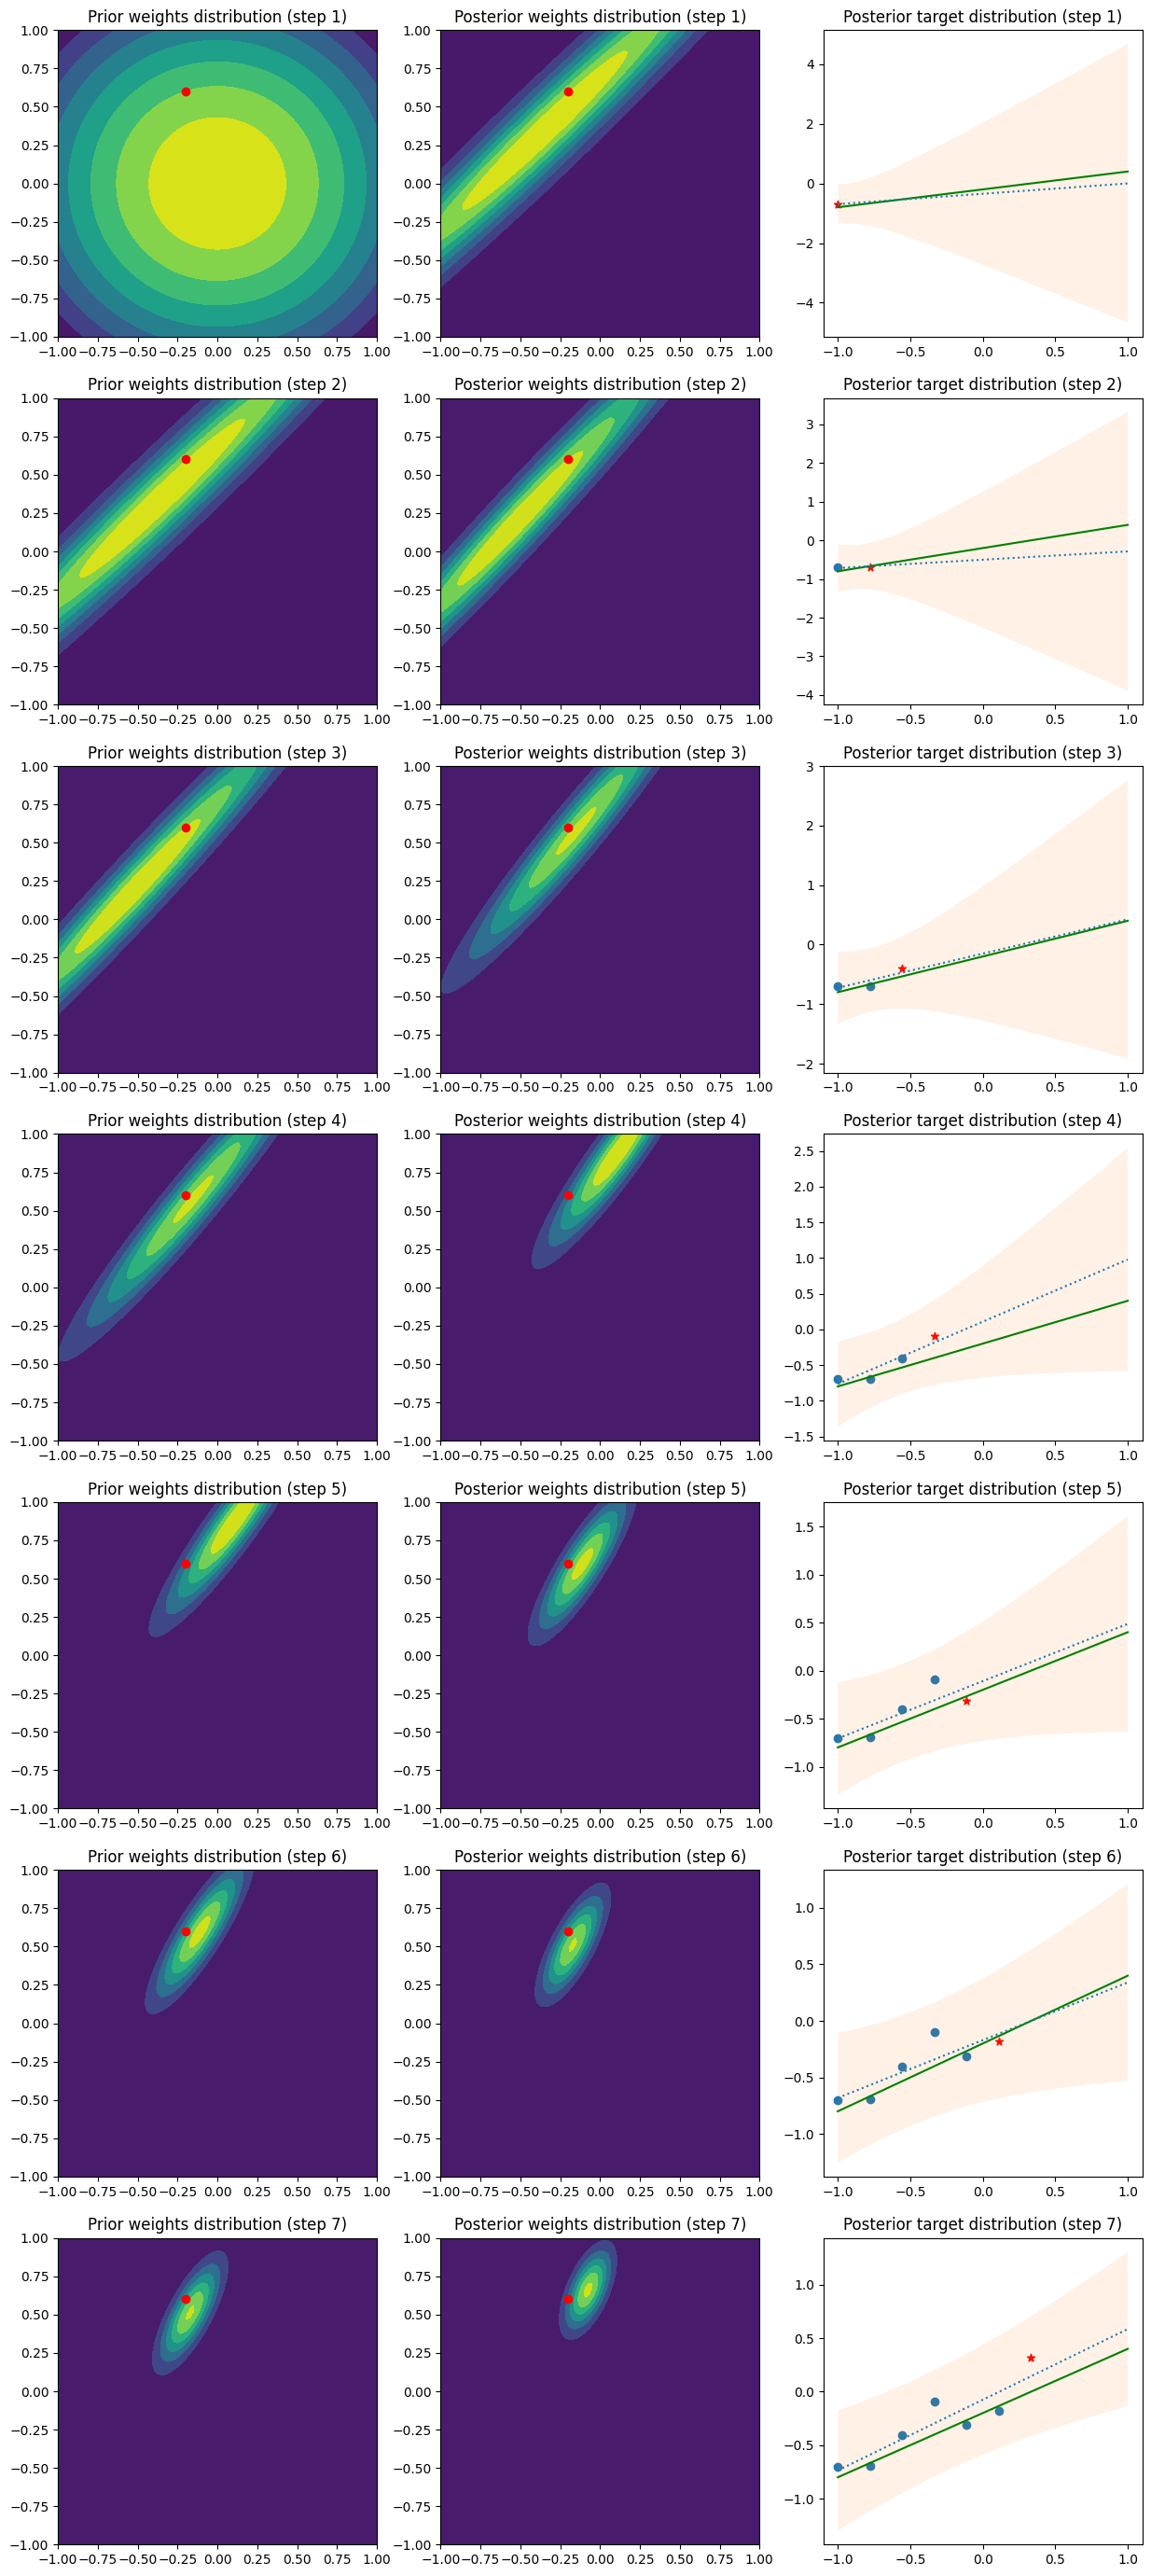

In [22]:
online_regressor = BayesianLinearRegression(n_features=1, alpha=2, beta=25)

visualize(online_regressor, 7, w0, w1)

### Comment

With online learning, the prior distribution converges to the point [w0, w1], which describes the coefficients of the line along which the data are given.